=== 1a. Kích thước dữ liệu ===
(336776, 21)

=== 1b. Kiểu dữ liệu ===
id                  int64
year                int64
month               int64
day                 int64
dep_time          float64
sched_dep_time      int64
dep_delay         float64
arr_time          float64
sched_arr_time      int64
arr_delay         float64
carrier            object
flight              int64
tailnum            object
origin             object
dest               object
air_time          float64
distance            int64
hour                int64
minute              int64
time_hour          object
name               object
dtype: object

=== 1c. Số lượng thực thể theo hãng bay (name) ===
name
United Air Lines Inc.          58665
JetBlue Airways                54635
ExpressJet Airlines Inc.       54173
Delta Air Lines Inc.           48110
American Airlines Inc.         32729
Envoy Air                      26397
US Airways Inc.                20536
Endeavor Air Inc.              18460
Southwest Airline

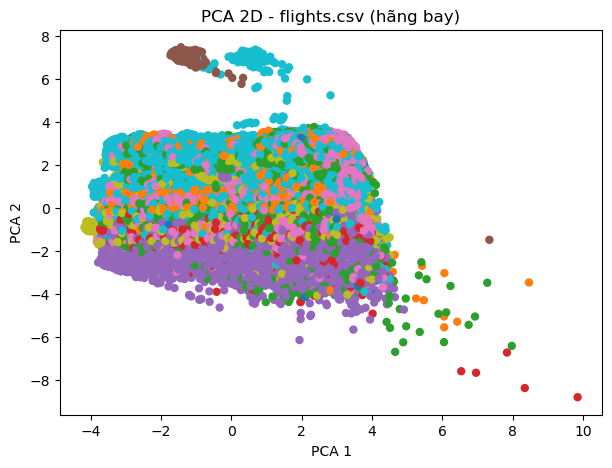


=== 3. Huấn luyện mô hình ===
KNN: F1_Macro=0.3283
RandomForest: F1_Macro=0.3955
SVM: F1_Macro=0.2016

=== Bảng so sánh hiệu năng các mô hình ===
          Model  F1 Score (Mean)
0           KNN         0.328331
1  RandomForest         0.395499
2           SVM         0.201610


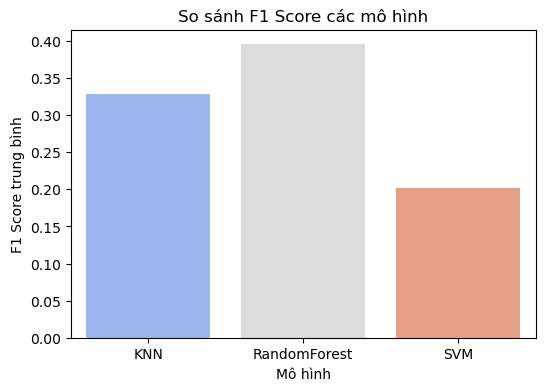


=== 4. Gom cụm K-Means & DBSCAN ===

=== K-Means ===
ARI: 0.016503097735266807
Silhouette: 0.18470107930805574

=== DBSCAN ===
ARI: 0.00043551241374056767
Silhouette: 0.5432077245486935


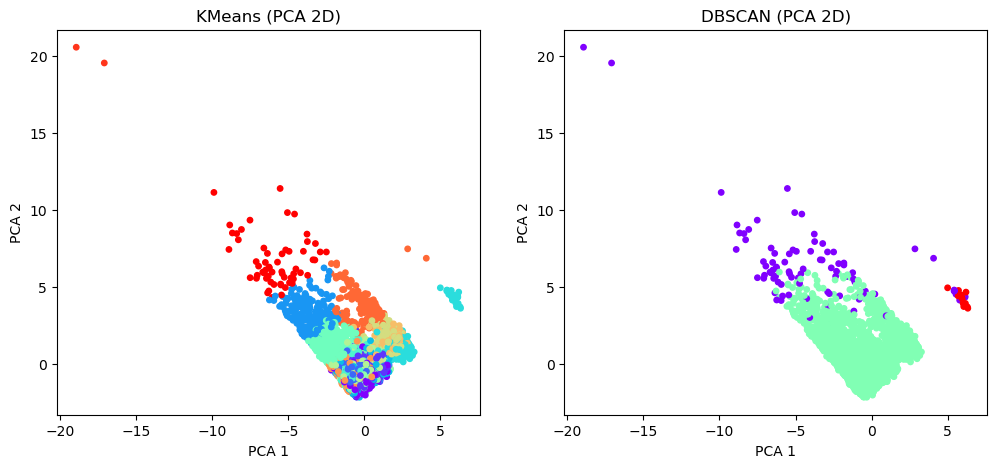

In [1]:
# =====================================
# PROJECT REALITY - Data Mining flights.csv (ổn định cho Windows)
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN

# ===========================================================
# 1. ĐỌC DỮ LIỆU & THỐNG KÊ CƠ BẢN
# ===========================================================
df = pd.read_csv("flights.csv")

print("=== 1a. Kích thước dữ liệu ===")
print(df.shape)
print("\n=== 1b. Kiểu dữ liệu ===")
print(df.dtypes)
print("\n=== 1c. Số lượng thực thể theo hãng bay (name) ===")
print(df['name'].value_counts())
print("\n=== 1d. Thống kê min / max / mean cho các cột số ===")
print(df.describe().T[['min','max','mean']])

# ===========================================================
# 2. PCA TRỰC QUAN HÓA DỮ LIỆU
# ===========================================================
numeric_cols = df.select_dtypes(include=[np.number]).columns
X_cont = df[numeric_cols].fillna(df[numeric_cols].mean())

label_col = 'name'
y = LabelEncoder().fit_transform(df[label_col].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cont)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='tab10', s=25)
plt.title("PCA 2D - flights.csv (hãng bay)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# ===========================================================
# 3. HUẤN LUYỆN MÔ HÌNH
# ===========================================================
import warnings
warnings.filterwarnings("ignore")

print("\n=== 3. Huấn luyện mô hình ===")

# Giữ lại các đặc trưng liên tục quan trọng
selected_cols = ['dep_delay', 'arr_delay', 'air_time', 'distance', 'month', 'hour', 'minute']
df_sample = df[selected_cols + ['name']].dropna().sample(n=10000, random_state=42)  # chỉ lấy 10k mẫu

X = df_sample[selected_cols]
y = LabelEncoder().fit_transform(df_sample['name'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    "SVM": SVC(C=1, kernel='rbf', random_state=42)
}

results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=1)
    results.append([name, scores.mean()])
    print(f"{name}: F1_Macro={scores.mean():.4f}")

results_df = pd.DataFrame(results, columns=['Model', 'F1 Score (Mean)'])
print("\n=== Bảng so sánh hiệu năng các mô hình ===")
print(results_df)

plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='F1 Score (Mean)', hue='Model', data=results_df, palette='coolwarm', legend=False)
plt.title("So sánh F1 Score các mô hình")
plt.ylabel("F1 Score trung bình")
plt.xlabel("Mô hình")
plt.show()

# ===========================================================
# 4. GOM CỤM K-MEANS & DBSCAN
# ===========================================================
print("\n=== 4. Gom cụm K-Means & DBSCAN ===")

# Dùng lại đúng tập mẫu 10k đã huấn luyện ở phần 3
X_cluster = X_scaled
true_labels = y

# PCA cho đúng kích thước (cùng X_cluster)
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X_cluster)

# --- KMeans ---
kmeans = KMeans(n_clusters=len(np.unique(true_labels)), random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_cluster)
print("\n=== K-Means ===")
print("ARI:", adjusted_rand_score(true_labels, kmeans_labels))
print("Silhouette:", silhouette_score(X_cluster, kmeans_labels))

# --- DBSCAN ---
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_cluster)
print("\n=== DBSCAN ===")
if len(set(dbscan_labels)) > 1:
    print("ARI:", adjusted_rand_score(true_labels, dbscan_labels))
    print("Silhouette:", silhouette_score(X_cluster, dbscan_labels))
else:
    print("DBSCAN gom toàn bộ vào 1 cụm hoặc nhiễu – không tính được Silhouette.")

# --- Trực quan 2D ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(X_pca_vis[:,0], X_pca_vis[:,1], c=kmeans_labels, cmap='rainbow', s=15)
axes[0].set_title("KMeans (PCA 2D)")
axes[1].scatter(X_pca_vis[:,0], X_pca_vis[:,1], c=dbscan_labels, cmap='rainbow', s=15)
axes[1].set_title("DBSCAN (PCA 2D)")
for ax in axes:
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
plt.show()